In [1]:
fasta_file = "/home/seungmolee/metagenomic_logan/esearch_dif_in_nt/nt_rhinovirus.fasta"

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import os, re, sys
sys.path.append("../")

import torch
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data
from itertools import product
from collections import defaultdict
from typing import List, Tuple, Dict, Optional

import metagnn as mg

from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

In [3]:
def load_fasta_as_dict(refseq_path):
    fasta_dict = {}
    with open(refseq_path, 'r') as f:
        header = None
        sequence = []
        
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                # Save the previous sequence before moving to the new header
                if header and sequence:
                    fasta_dict[header] = "".join(sequence)
                header = line[1:]  # Store header without '>'
                sequence = []      # Reset sequence list for new header
            else:
                sequence.append(line)  # Add sequence line to current sequence
        
        # Add the last sequence
        if header and sequence:
            fasta_dict[header] = "".join(sequence)
    
    return fasta_dict

refseq_path = "../data/refseq_viruses.fasta"
fasta_dict = load_fasta_as_dict(refseq_path)

In [4]:
def encode_sequences(sequences, max_length):
    # Mapping for encoding nucleotides
    mapping = {'A': [1, 0, 0, 0], 
               'C': [0, 1, 0, 0], 
               'G': [0, 0, 1, 0], 
               'T': [0, 0, 0, 1]}
    
    # Convert mapping to a tensor for fast indexing
    # max_length = max(len(s) for s in sequences)
    
    mapping_tensor = torch.tensor([mapping.get(char, [0, 0, 0, 0]) for char in "ACGT"], dtype=torch.float32)
    mapping_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}  # Indexes in mapping_tensor for fast lookup
    
    # Initialize a list to store encoded sequences
    encoded_sequences = []

    iterator = tqdm(sequences)
    for sequence in iterator:
        # Convert each nucleotide to its respective encoding index
        indices = [mapping_dict[char] for char in sequence if char in mapping_dict]
        
        # Use indices to gather rows from the mapping tensor
        encoding = mapping_tensor[indices]
        encoding = torch.fft.fft(encoding, dim=1)
        
        # Pad if the encoded sequence is shorter than max_length
        if encoding.shape[0] < max_length:
            padding = torch.zeros((max_length - encoding.shape[0], 4), dtype=torch.float32)
            encoding = torch.cat([encoding, padding], dim=0)
        else:
            encoding = encoding[:max_length]  # Truncate if longer than max_length
            
        encoded_sequences.append(encoding)
    
    # Stack all encoded sequences to create a 3D tensor
    return torch.stack(encoded_sequences)

In [5]:
enc_seq = encode_sequences(list(fasta_dict.values()), 5000)

  0%|          | 0/18750 [00:00<?, ?it/s]

In [8]:
def compute_similarity_matrix(fft_seqs):
    """
    Compute a similarity matrix for a batch of sequences using cross-correlation of FFTs.
    
    Parameters:
        fft_seqs (torch.Tensor): Tensor of shape [n_obs, max_length, 4].
        
    Returns:
        torch.Tensor: Similarity matrix of shape [n_obs, n_obs].
    """
    # Equivalent to torch.einsum('ilk,jlk->ij', fft_seqs, fft_seqs_conj)
    fft_seqs_flat = fft_seqs.view(fft_seqs.shape[0], -1)  # [n_obs, length * 4]
    similarity_matrix = torch.abs(fft_seqs_flat @ torch.conj(fft_seqs_flat).T) # [n_obs, n_obs]

    # Normalize
    magnitudes = torch.sqrt(torch.sum(torch.abs(fft_seqs_flat) ** 2, dim=1, keepdim=True))
    similarity_matrix /= (magnitudes @ magnitudes.T + 1e-8)

    return similarity_matrix

In [7]:
def frobenius_norm(matrix):
    """
    Compute the Frobenius norm of a matrix.
    
    Parameters:
        matrix (torch.Tensor): Input tensor.
        
    Returns:
        torch.Tensor: The Frobenius norm, a scalar value.
    """
    matrix = matrix.clone().fill_diagonal_(0)
    return torch.sqrt(torch.sum(torch.abs(matrix) ** 2) / matrix.size(0))

In [6]:
def frobenius_norm_cross_correlation(fft_seqs):
    """
    Compute the Frobenius norm of the off-diagonal elements using block operations
    for better space efficiency.
    
    Parameters:
        fft_seqs (torch.Tensor): Tensor of shape [n_obs, max_length, 4]
    Returns:
        torch.Tensor: Frobenius norm of the off-diagonal elements
    """
    # Flatten fft_seqs for correlation
    fft_seqs_flat = fft_seqs.view(fft_seqs.shape[0], -1)
    
    # Compute magnitudes once
    magnitudes = torch.sqrt(torch.sum(torch.abs(fft_seqs_flat) ** 2, dim=1))
    
    # Compute matrix-vector products in chunks and accumulate squared values
    block_size = 1  # Adjust based on available memory
    n_blocks = (fft_seqs_flat.shape[0] + block_size - 1) // block_size
    
    frobenius_sum = torch.zeros(1, device=fft_seqs.device)
    for i in range(n_blocks):
        start_idx = i * block_size
        end_idx = min((i + 1) * block_size, fft_seqs_flat.shape[0])
        
        # Compute block of similarity matrix
        block = torch.abs(fft_seqs_flat[start_idx:end_idx] @ torch.conj(fft_seqs_flat).T)
        block = block / (magnitudes[start_idx:end_idx, None] * magnitudes[None, :] + 1e-8)
        
        # Zero out diagonal elements in this block
        if start_idx < end_idx:
            block.diagonal()[max(-start_idx, 0):] = 0
            
        # Accumulate squared values
        frobenius_sum += torch.sum(block ** 2)

    return torch.sqrt(frobenius_sum / fft_seqs.shape[0])

tensor(2.8784)


/home/seungmolee/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/seungmolee/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/tmp/ipykernel_18853/3995965464.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


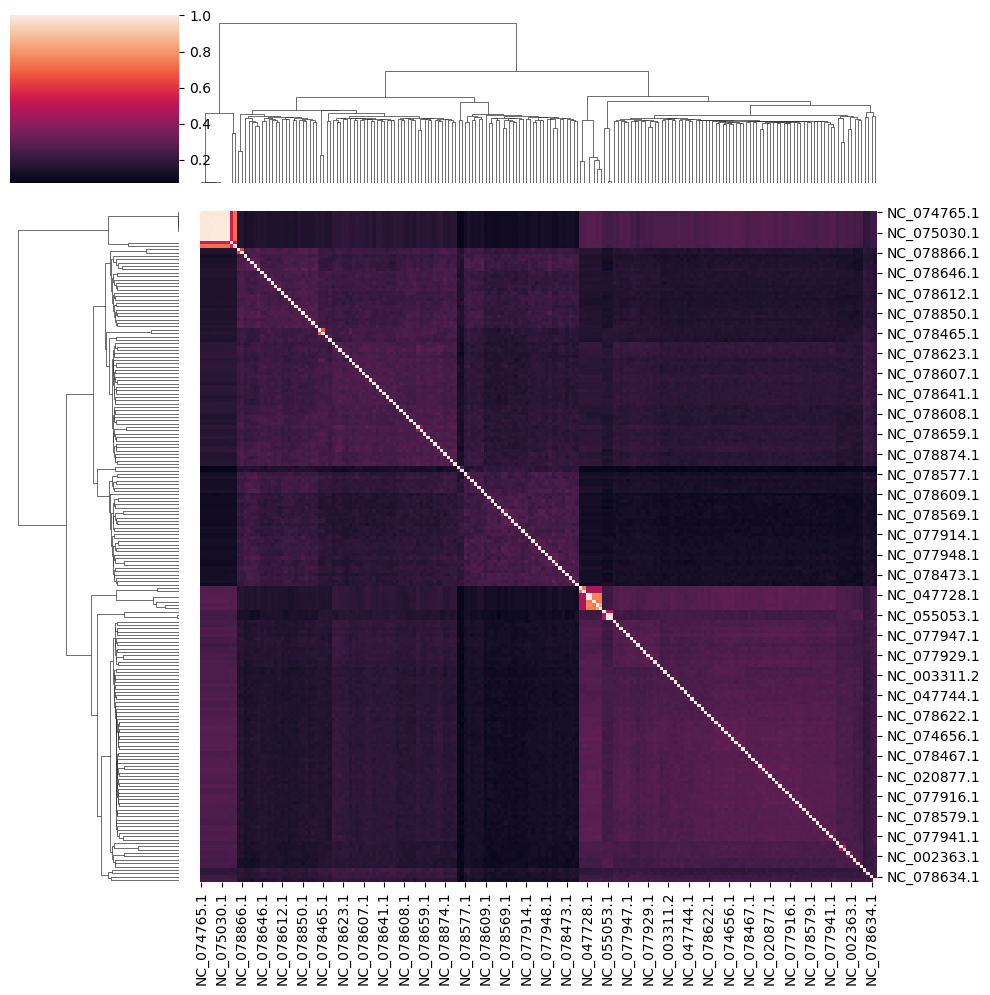

In [9]:
window = (100,300)
names = list(fasta_dict.keys())[window[0]:window[1]]
names = [re.match(r"^\S+", name).group() for name in names]
sim_mtx = compute_similarity_matrix(enc_seq[window[0]:window[1]])
print(frobenius_norm(sim_mtx))
view_data = pd.DataFrame(sim_mtx, index=names, columns=names)
sns.clustermap(data=view_data)
plt.tight_layout()

In [ ]:
class DeBruijnGraphs:
    def __init__(self, k_values: List[int] = [4, 5, 6]):
        """
        Initialize DeBruijn graph generator for multiple k values.
        """
        self.k_values = [k_values] if isinstance(k_values, int) else k_values
        self.kmer_maps = {k: self._generate_kmer_map(k) for k in k_values}
        # Create reverse mapping for node feature generation
        self.idx_to_kmer = {
            k: {idx: kmer for kmer, idx in kmer_map.items()}
            for k, kmer_map in self.kmer_maps.items()
        }
    
    def _generate_kmer_map(self, k: int) -> Dict[str, int]:
        """Generate mapping of (k-1)-mers to indices."""
        return {
            ''.join(kmer): i 
            for i, kmer in enumerate([''.join(p) for p in product('ACGT', repeat=k-1)])
        }
    
    def get_num_nodes(self, k: int) -> int:
        """Get number of nodes for a given k value."""
        return 4 ** (k-1)
    
    def count_kmers(self, sequence: str, k: int) -> torch.Tensor:
        """
        Count frequencies of (k-1)-mers in the sequence.
        
        Args:
            sequence: Input DNA sequence
            k: k-mer size (will count (k-1)-mers for nodes)
            
        Returns:
            Tensor of shape (4^(k-1),) containing normalized frequencies
        """
        kmer_len = k - 1
        num_nodes = self.get_num_nodes(k)
        kmer_to_idx = self.kmer_maps[k]
        
        # Count (k-1)-mers
        kmer_counts = defaultdict(int)
        for i in range(len(sequence) - kmer_len + 1):
            kmer = sequence[i:i+kmer_len]
            if set(kmer).issubset({'A', 'C', 'G', 'T'}):
                kmer_counts[kmer] += 1
        
        # Convert to tensor
        counts = torch.zeros(num_nodes, dtype=torch.float32)
        for kmer, count in kmer_counts.items():
            if kmer in kmer_to_idx:
                counts[kmer_to_idx[kmer]] = count
        
        # Normalize frequencies
        total_counts = counts.sum()
        if total_counts > 0:
            counts = counts / total_counts
            
        return counts
    
    def generate_pyg_data(self, sequence: str, k: int) -> Data:
        """
        Generate PyG Data object with k-mer frequency node features.
    
        Args:
            sequence: Input DNA sequence
            k: k-mer size
    
        Returns:
            PyG Data object containing:
                - x: Node features (normalized k-mer frequencies)
                - edge_index: Edge connectivity
                - edge_attr: Log-normalized edge weights
                - kmer_map: Dictionary mapping node indices to their k-mer sequences
        """
        kmer_to_idx = self.kmer_maps[k]
        edge_counts = defaultdict(int)
        num_nodes = self.get_num_nodes(k)
        
        # Generate node features from k-mer frequencies
        x = self.count_kmers(sequence, k)
        
        # Count edges
        for i in range(len(sequence) - k + 1):
            kmer = sequence[i:i+k]
            if set(kmer).issubset({'A', 'C', 'G', 'T'}):
                prefix_idx = kmer_to_idx[kmer[:-1]]
                suffix_idx = kmer_to_idx[kmer[1:]]
                edge_counts[(prefix_idx, suffix_idx)] += 1
        
        # Convert to tensors
        if edge_counts:
            edges, weights = zip(*((edge, count) for edge, count in edge_counts.items()))
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
            
            # Log-normalize edge weights
            weights_tensor = torch.tensor(weights, dtype=torch.float32)
            log_weights = torch.log(weights_tensor + 1e-8)  # Avoid log(0) by adding epsilon
            edge_attr = (log_weights / log_weights.sum()).unsqueeze(1)
        else:
            edge_index = torch.zeros((2, 0), dtype=torch.long)
            edge_attr = torch.zeros((0, 1), dtype=torch.float32)
        
        # Create mapping of node indices to their k-mer sequences
        kmer_map = self.idx_to_kmer[k]
        
        return Data(
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            num_nodes=num_nodes,
            kmer_map=kmer_map  # Store k-mer mapping for interpretation
        )
    
    def batch_process_sequences(self, 
                              sequences: List[str],
                              show_progress: bool = True) -> Dict[int, List[Data]]:
        """Process multiple sequences for all k values."""
        graphs = {k: [] for k in self.k_values}
        iterator = tqdm(sequences, desc="Building graphs") if show_progress else sequences
        
        for seq in iterator:
            for k in self.k_values:
                graphs[k].append(self.generate_pyg_data(seq, k))
                
        return graphs

In [ ]:
from torch.utils.data import Dataset

In [14]:
class MetagenomeDataset(Dataset):
    def __init__(self, fasta_file: str, max_length: int=5000, k: List[int]=[4,5]):
        self.headers, self.sequences = self.load_fasta(fasta_file)
        self.max_length = max_length
        
        self.fft = self.encode_sequences(self.sequences)
        self.debruijn = DeBruijnGraphs(k_values=k)
        self.graphs = self.debruijn.batch_process_sequences(self.sequences)
    
    def __len__(self):
        return len(self.headers)
    
    def __getitem__(self, idx):
        """
        Retrieve the FFT-transformed sequence and DeBruijn graph data for a given index,
        supporting multiple k values.
        
        Args:
            idx: Index of the sample to retrieve
        
        Returns:
            A dictionary containing:
                - 'fft_seq': FFT-transformed sequence data
                - 'graphs': A dictionary mapping each k to its corresponding DeBruijn graph data
        """
        fft = self.fft[idx, ...]
        
        # Gather graphs for all k values
        graphs = {k: self.graphs[k][idx] for k in self.debruijn.k_values}
        
        return {'fft': fft, 'graphs': graphs}
    
    def load_fasta(self, fasta_file):
        headers = []
        sequences = []
        with open(fasta_file, 'r') as file:
            header = None
            sequence = []
    
            file_iterator = tqdm(file, desc="Loading fasta")
            for line in file_iterator:
                line = line.strip()
                if line.startswith(">"):
                    if header and sequence:
                        headers.append(header)
                        sequences.append("".join(sequence))
                    header = line[1:]  # Store header without '>'
                    sequence = []      # Reset sequence list for new header
                else:
                    sequence.append(line)  # Add sequence line to current sequence
            
            # Add the last header and sequence
            if header and sequence:
                headers.append(header)
                sequences.append("".join(sequence))
        
        return headers, sequences

    def encode_sequences(self, sequences):
        # Mapping for encoding nucleotides
        mapping = {'A': [1, 0, 0, 0], 
                   'C': [0, 1, 0, 0], 
                   'G': [0, 0, 1, 0], 
                   'T': [0, 0, 0, 1]}
        
        mapping_tensor = torch.tensor([mapping.get(char, [0, 0, 0, 0]) for char in "ACGT"], dtype=torch.float32)
        mapping_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}  # Indexes in mapping_tensor for fast lookup
        
        # Initialize a list to store encoded sequences
        encoded_sequences = []
    
        iterator = tqdm(sequences, desc="Encoding sequences")
        for sequence in iterator:
            # Convert each nucleotide to its respective encoding index
            indices = [mapping_dict[char] for char in sequence if char in mapping_dict]
            
            # Use indices to gather rows from the mapping tensor
            encoding = mapping_tensor[indices]
            encoding = torch.fft.fft(encoding, dim=1)
            
            # Pad if the encoded sequence is shorter than max_length
            if encoding.shape[0] < self.max_length:
                padding = torch.zeros((self.max_length - encoding.shape[0], 4), dtype=torch.float32)
                encoding = torch.cat([encoding, padding], dim=0)
            else:
                encoding = encoding[:self.max_length]  # Truncate if longer than max_length
                
            encoded_sequences.append(encoding)
        
        # Stack all encoded sequences to create a 3D tensor
        return torch.stack(encoded_sequences)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import numpy as np
from tqdm import tqdm

class DeBruijnGraphs:
    def __init__(self, k_values=[4, 5]):
        self.k_values = k_values
        self.kmer_to_idx = {k: {} for k in k_values}
        self.next_idx = {k: 0 for k in k_values}
    
    def sequence_to_graph(self, sequence, k):
        """Convert sequence to DeBruijn graph representation"""
        edges = []
        edge_weights = defaultdict(int)
        
        # Generate k-mers and edges
        for i in range(len(sequence) - k):
            kmer1 = sequence[i:i+k]
            kmer2 = sequence[i+1:i+k+1]
            
            # Get or assign indices for kmers
            if kmer1 not in self.kmer_to_idx[k]:
                self.kmer_to_idx[k][kmer1] = self.next_idx[k]
                self.next_idx[k] += 1
            if kmer2 not in self.kmer_to_idx[k]:
                self.kmer_to_idx[k][kmer2] = self.next_idx[k]
                self.next_idx[k] += 1
            
            idx1 = self.kmer_to_idx[k][kmer1]
            idx2 = self.kmer_to_idx[k][kmer2]
            edge = (idx1, idx2)
            edge_weights[edge] += 1
        
        # Convert to PyTorch tensors
        if edges:
            edges = list(edge_weights.keys())
            weights = list(edge_weights.values())
            edge_index = torch.tensor(edges, dtype=torch.long).t()
            edge_attr = torch.tensor(weights, dtype=torch.float)
            num_nodes = self.next_idx[k]
            
            # Create node features (could be enhanced)
            x = torch.ones((num_nodes, 1), dtype=torch.float)
            
            return {'edge_index': edge_index, 
                   'edge_attr': edge_attr, 
                   'x': x, 
                   'num_nodes': num_nodes}
        return None
    
    def batch_process_sequences(self, sequences):
        """Process multiple sequences into graphs for each k value"""
        graphs = {k: [] for k in self.k_values}
        
        for sequence in tqdm(sequences, desc="Creating DeBruijn graphs"):
            for k in self.k_values:
                graph = self.sequence_to_graph(sequence, k)
                if graph is not None:
                    graphs[k].append(graph)
        
        return graphs

class FFTEncoder(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        
    def forward(self, x):
        # x shape: [batch_size, seq_length, 4]
        x = x.permute(0, 2, 1)  # [batch_size, 4, seq_length]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        return x.squeeze(-1)  # [batch_size, hidden_dim]

class GraphEncoder(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.conv1 = GCNConv(1, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        # Global pooling to get graph-level representation
        x = global_mean_pool(x, data.batch)
        return x

class MetagenomicClassifier(nn.Module):
    def __init__(self, num_classes, hidden_dim=64, k_values=[4, 5]):
        super().__init__()
        self.k_values = k_values
        
        # FFT encoder
        self.fft_encoder = FFTEncoder(input_dim=4, hidden_dim=hidden_dim)
        
        # Graph encoder for each k value
        self.graph_encoders = nn.ModuleDict({
            f'k{k}': GraphEncoder(hidden_dim=hidden_dim)
            for k in k_values
        })
        
        # Final classification layers
        total_features = hidden_dim * (len(k_values) + 1)  # FFT + all k-mer graphs
        self.classifier = nn.Sequential(
            nn.Linear(total_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, fft_seq, graphs):
        # Encode FFT sequence
        fft_features = self.fft_encoder(fft_seq)
        
        # Encode graphs for each k value
        graph_features = []
        for k in self.k_values:
            graph_enc = self.graph_encoders[f'k{k}'](graphs[k])
            graph_features.append(graph_enc)
        
        # Concatenate all features
        combined_features = torch.cat([fft_features] + graph_features, dim=1)
        
        # Final classification
        logits = self.classifier(combined_features)
        return logits

def train_model(model, train_loader, val_loader, num_epochs=10):
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            optimizer.zero_grad()
            
            fft_seq = batch['fft']
            graphs = batch['graphs']
            labels = batch['labels']
            
            outputs = model(fft_seq, graphs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                fft_seq = batch['fft']
                graphs = batch['graphs']
                labels = batch['labels']
                
                outputs = model(fft_seq, graphs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        print(f'Epoch {epoch+1}: '
              f'Train Loss: {train_loss/len(train_loader):.4f}, '
              f'Val Loss: {val_loss/len(val_loader):.4f}, '
              f'Val Acc: {100.*correct/total:.2f}%')

In [16]:
dataset = MetagenomeDataset(fasta_file="../data/refseq_viruses.fasta", max_length=5000, k=[4, 5])
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

Loading fasta: 9626331it [00:03, 2890404.41it/s]
Creating DeBruijn graphs: 100%|████████████████████████████████████████████████████████████████████████████████████████| 18750/18750 [14:00<00:00, 22.30it/s]


In [22]:
import torch
from torch.utils.data import Dataset
from collections import defaultdict
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data

class DeBruijnGraphs:
    def __init__(self, k_values=[4, 5]):
        self.k_values = k_values
        self.kmer_to_idx = defaultdict(lambda: defaultdict(lambda: len(self.kmer_to_idx)))
    
    def sequence_to_graph(self, sequence, k):
        """Convert sequence to DeBruijn graph representation"""
        edges = []
        edge_weights = defaultdict(int)
        kmers = {}  # Store all kmers and their indices
        
        # Generate k-mers and edges
        for i in range(len(sequence) - k):
            kmer1 = sequence[i:i+k]
            kmer2 = sequence[i+1:i+k+1]
            
            # Get indices for kmers
            idx1 = self.kmer_to_idx[k][kmer1]
            idx2 = self.kmer_to_idx[k][kmer2]
            
            kmers[kmer1] = idx1
            kmers[kmer2] = idx2
            
            edge = (idx1, idx2)
            edge_weights[edge] += 1
        
        if not edge_weights:
            return None
            
        # Convert to PyTorch tensors
        edges = list(edge_weights.keys())
        weights = list(edge_weights.values())
        edge_index = torch.tensor(edges, dtype=torch.long).t()
        edge_attr = torch.tensor(weights, dtype=torch.float)
        
        # Create node features (could be enhanced)
        num_nodes = len(kmers)
        x = torch.ones((num_nodes, 1), dtype=torch.float)
        
        # Create PyTorch Geometric Data object
        data = Data(
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            num_nodes=num_nodes
        )
        
        return data
    
    def batch_process_sequences(self, sequences):
        """Process multiple sequences into graphs for each k value"""
        graphs = {k: [] for k in self.k_values}
        
        for sequence in tqdm(sequences, desc="Creating DeBruijn graphs"):
            for k in self.k_values:
                graph = self.sequence_to_graph(sequence, k)
                if graph is not None:
                    graphs[k].append(graph)
                else:
                    # Add empty graph to maintain sequence alignment
                    empty_graph = Data(
                        x=torch.ones((1, 1), dtype=torch.float),
                        edge_index=torch.zeros((2, 0), dtype=torch.long),
                        edge_attr=torch.zeros(0, dtype=torch.float),
                        num_nodes=1
                    )
                    graphs[k].append(empty_graph)
        
        return graphs

class MetagenomeDataset(Dataset):
    def __init__(self, fasta_file: str, max_length: int=5000, k=[4,5]):
        self.max_length = max_length
        self.headers, self.sequences = self.load_fasta(fasta_file)
        
        print(f"Loaded {len(self.sequences)} sequences")
        
        # Create FFT encodings
        print("Creating FFT encodings...")
        self.fft = self.encode_sequences(self.sequences)
        
        # Create De Bruijn graphs
        print("Creating De Bruijn graphs...")
        self.debruijn = DeBruijnGraphs(k_values=k)
        self.graphs = self.debruijn.batch_process_sequences(self.sequences)
        
        print("Dataset initialization complete")
        print(f"FFT shape: {self.fft.shape}")
        for k_val in k:
            print(f"Number of graphs for k={k_val}: {len(self.graphs[k_val])}")
    
    def __len__(self):
        return len(self.headers)
    
    def __getitem__(self, idx):
        fft = self.fft[idx]
        graphs = {k: self.graphs[k][idx] for k in self.debruijn.k_values}
        return {'fft': fft, 'graphs': graphs}
    
    def load_fasta(self, fasta_file):
        headers = []
        sequences = []
        with open(fasta_file, 'r') as file:
            header = None
            sequence = []
            
            for line in tqdm(file, desc="Loading fasta"):
                line = line.strip()
                if line.startswith(">"):
                    if header and sequence:
                        headers.append(header)
                        sequences.append("".join(sequence))
                    header = line[1:]
                    sequence = []
                else:
                    sequence.append(line)
            
            if header and sequence:
                headers.append(header)
                sequences.append("".join(sequence))
        
        return headers, sequences
    
    def encode_sequences(self, sequences):
        # Your existing encode_sequences implementation...
        mapping = {'A': [1, 0, 0, 0], 
                  'C': [0, 1, 0, 0], 
                  'G': [0, 0, 1, 0], 
                  'T': [0, 0, 0, 1]}
        
        mapping_tensor = torch.tensor([mapping.get(char, [0, 0, 0, 0]) for char in "ACGT"], dtype=torch.float32)
        mapping_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
        
        encoded_sequences = []
        for sequence in tqdm(sequences, desc="Encoding sequences"):
            indices = [mapping_dict[char] for char in sequence if char in mapping_dict]
            encoding = mapping_tensor[indices]
            encoding = torch.fft.fft(encoding, dim=1)
            
            if encoding.shape[0] < self.max_length:
                padding = torch.zeros((self.max_length - encoding.shape[0], 4), dtype=torch.float32)
                encoding = torch.cat([encoding, padding], dim=0)
            else:
                encoding = encoding[:self.max_length]
                
            encoded_sequences.append(encoding)
        
        return torch.stack(encoded_sequences)

def visualize_debruijn_graph(dataset, sequence_idx, k_value, figsize=(15, 10)):
    """Visualize the De Bruijn graph for a specific sequence"""
    if sequence_idx >= len(dataset.sequences):
        raise ValueError(f"sequence_idx {sequence_idx} out of range")
    if k_value not in dataset.debruijn.k_values:
        raise ValueError(f"k_value {k_value} not in {dataset.debruijn.k_values}")
    
    graph_data = dataset.graphs[k_value][sequence_idx]
    
    # Convert to networkx for visualization
    G = nx.DiGraph()
    
    # Add edges from edge_index
    edge_index = graph_data.edge_index.t().numpy()
    edge_weights = graph_data.edge_attr.numpy()
    
    for i, (src, dst) in enumerate(edge_index):
        G.add_edge(int(src), int(dst), weight=float(edge_weights[i]))
    
    # Visualization
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G)
    
    # Draw the graph
    nx.draw(G, pos, 
            node_color='lightblue',
            node_size=500,
            arrowsize=20,
            with_labels=True,
            font_weight='bold')
    
    plt.title(f"De Bruijn Graph (k={k_value})\nSequence {sequence_idx}")
    plt.show()

Loading fasta: 9626331it [00:03, 2867582.44it/s]


Loaded 18750 sequences
Creating FFT encodings...


Encoding sequences: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 18750/18750 [02:28<00:00, 126.14it/s]


Creating De Bruijn graphs...


Creating DeBruijn graphs: 100%|████████████████████████████████████████████████████████████████████████████████████████| 18750/18750 [13:06<00:00, 23.83it/s]


Dataset initialization complete
FFT shape: torch.Size([18750, 5000, 4])
Number of graphs for k=4: 18750
Number of graphs for k=5: 18750


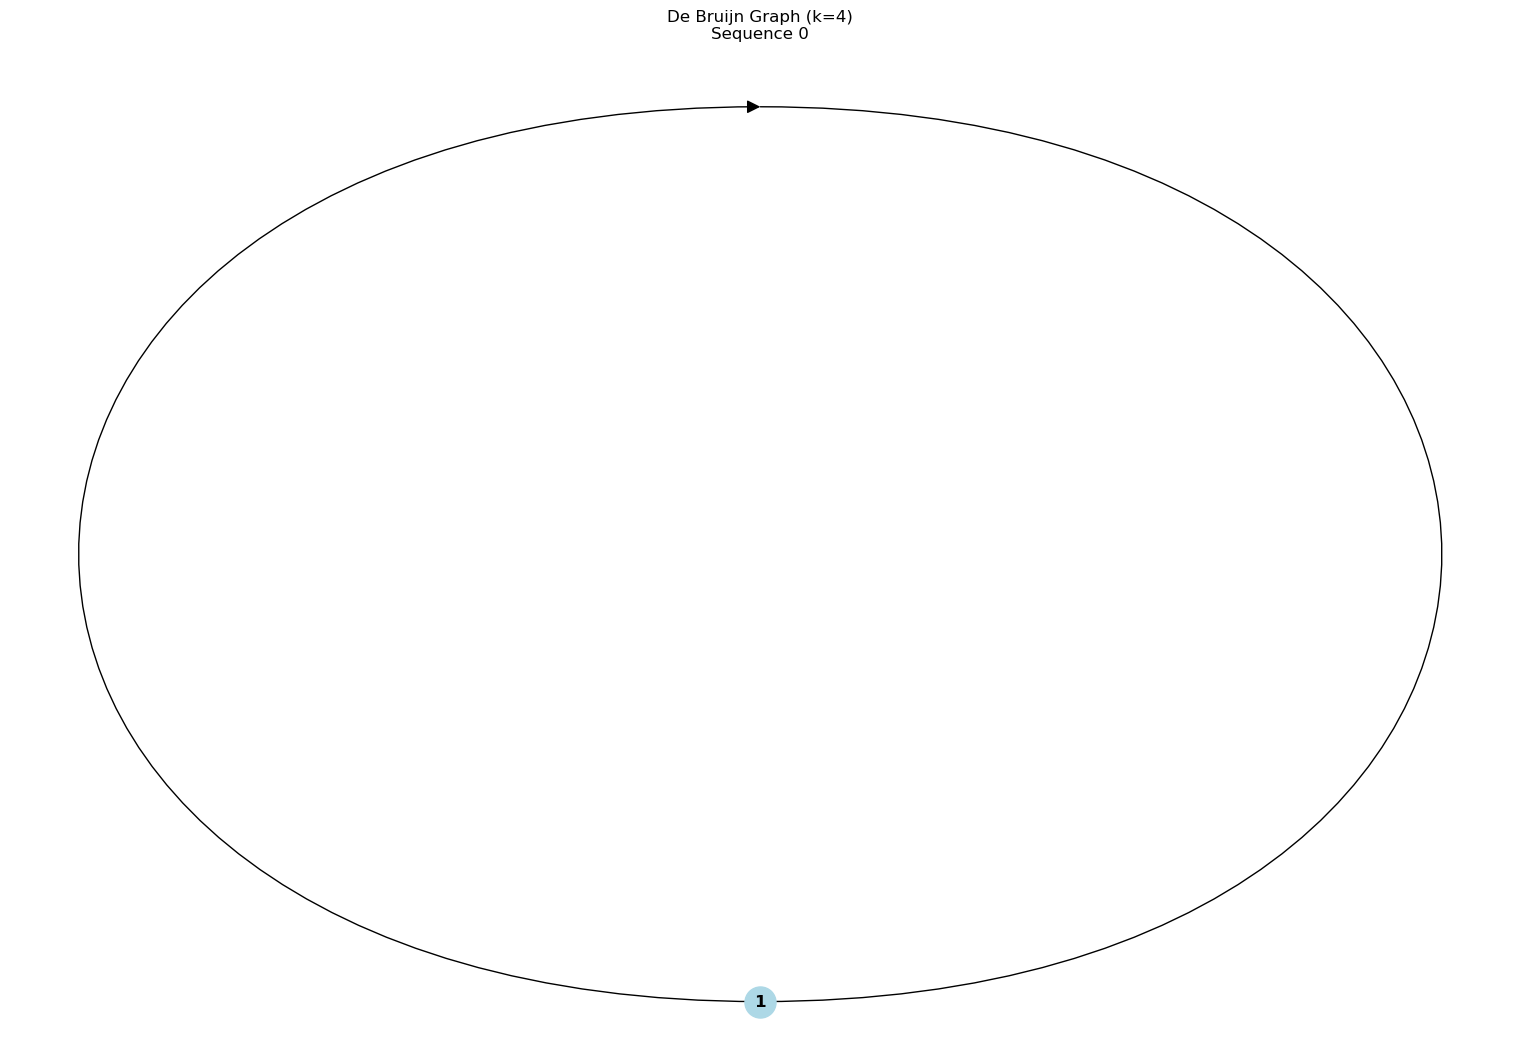

In [23]:
dataset = MetagenomeDataset(fasta_file="../data/refseq_viruses.fasta", max_length=5000, k=[4, 5])

# Visualize the graph for the first sequence with k=4
visualize_debruijn_graph(dataset, sequence_idx=0, k_value=4)

In [ ]:
k = 4
graph_data = dataset.graphs[k][0]
print(f"Number of nodes: {graph_data.num_nodes}")
print(f"Number of edges: {graph_data.edge_index.shape[1]}")
print(f"Edge weight range: {graph_data.edge_attr.min().item():.2f} - {graph_data.edge_attr.max().item():.2f}")

In [ ]:
model = MetagenomicClassifier(num_classes=num_virus_types)
train_model(model, train_loader, val_loader)